# Utilities

In [5]:
import matplotlib.pyplot as plt
from jupyterthemes import jtplot
import matplotlib as mpl
from scipy.integrate import odeint
from numpy import linalg as LA
from scipy.optimize import fsolve
from scipy.optimize import curve_fit
mpl.rcdefaults() 
from scipy.stats import uniform
import scipy.stats as st
from matplotlib import colors
from matplotlib import cm
import pandas as pd
import datetime
from mpl_toolkits.axes_grid1 import make_axes_locatable
import cartopy.crs as ccrs
import cartopy
import json
import xarray as xr
import pickle
from scipy.stats import linregress
from EWS_functions import *
from scipy.optimize import curve_fit
from scipy.ndimage import gaussian_filter1d

jtplot.style(context='paper', fscale=1.4, spines=True, grid=False, ticks=True,gridlines='--')

fontsize=16
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['ytick.direction'] = 'in'
mpl.rcParams['xtick.top'] = True
mpl.rcParams['ytick.right'] = True

mpl.rcParams['font.size'] = 16
mpl.rcParams['legend.fontsize'] = 'large'
mpl.rcParams['figure.titlesize'] = 'medium'
mpl.rcParams['axes.labelsize']= 'x-large'
mpl.rcParams['figure.facecolor']='white'

mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = ['Arial']
hfont = {'fontname':'Arial'}

mpl.rcParams['text.latex.preamble']= r'\usepackage{amsmath}'
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=['#1b9e77','#d95f02','#7570b3','#e7298a','#66a61e','#e6ab02','#a6761d','#666666']) 

## EWS plot functions

In [1]:
def get_EWS(time,data,trend,ws):
    linfits = []
    ps = []
    bound = ws // 2
    
    std = runstd(data - trend, ws)[bound:-bound]
    p0, p1 = np.polyfit(time[bound : -bound][:-2], std[:-2], 1)
    linfits.append([p0,p1])
    ps.append(kendall_tau_test(std[:-2], 1000, p0))
    
    ar1 = runac(data - trend, ws)[bound : -bound]
    p0, p1 = np.polyfit(time[bound : -bound][:-3], ar1[:-3], 1)
    linfits.append([p0,p1])
    ps.append(kendall_tau_test(ar1[:-2], 1000, p0))
    
    lam = run_fit_a_ar1(data-trend,ws)[bound:-bound]
    p0, p1 = np.polyfit(time[bound : -bound][:-2], lam[:-2], 1)
    linfits.append([p0,p1])
    ps.append(kendall_tau_test(lam[:-2], 1000, p0))
    
    return std, ar1, lam, linfits, ps

In [2]:
def plot_EWS(data, timess, ws=70, col='k',lbl='',alph=1,lw=1):
    bound = ws // 2
    popt, cov = curve_fit(funcfit3, timess, data, p0 = [-8.33097773e-01,  1.05507897e-02,  2.02518923e+03], maxfev = 1000000000)
    trend = funcfit3(timess, *popt)
    std, ar1, lam, linfits, ps = get_EWS(timess,data,trend,ws)

    ax1.plot(timess[bound : -bound],std,color=col,label=lbl,alpha=alph,lw=lw)
    pv = kendall_tau_test(std[:-2],1000,linfits[1][0])
    ax1.plot(timess[bound : -bound][:-2],linfits[0][0] * timess[bound : -bound][:-2] + linfits[0][1],linestyle='--',color=col,alpha=alph,lw=lw,label="p = {:.3f}".format(pv))

    ax2.plot(timess[bound : -bound],ar1,color=col,label=lbl,alpha=alph,lw=lw)
    pv = kendall_tau_test(ar1[:-2],1000,linfits[1][0])
    ax2.plot(timess[bound : -bound][:-2],linfits[1][0] * timess[bound : -bound][:-2] + linfits[1][1],linestyle='--',color=col,alpha=alph,lw=lw,label="p = {:.3f}".format(pv))

    ax3.plot(timess[bound : -bound],lam,color=col,label=lbl,alpha=alph,lw=lw)
    p0, p1, p2 = np.polyfit(timess[bound : -bound][:-2], lam[:-2], 2)
    pl0, pl1  = np.polyfit(timess[bound : -bound][:-2], lam[:-2], 1)
    pv = kendall_tau_test(lam[:-2], 1000, pl0) # precentile of 1000 fourier surrogates have a larger linear slope
#     ax3.plot(timess[bound : -bound][:-2], p0 * timess[bound : -bound][:-2]**2+p1 * timess[bound : -bound][:-2] + p2, color=col,linestyle='--',alpha=alph,lw=lw,label="p = {:.3f}".format(pv))
    ax3.plot(timess[bound : -bound][:-2], pl0 * timess[bound : -bound][:-2] + pl1, color=col,linestyle='--',alpha=alph,lw=lw,label="p = {:.3f}".format(pv))

# files

In [13]:
ds = xr.open_dataset('DAMIP_amoc.nc')
damip_strn = ds.amoc_damip.sel(latitudes='26.5N')
damip_index = ds.index_damip

In [9]:
aer = xr.open_dataarray('hist_aer_amoc_index.nc').groupby('time.year').mean('time')
nat = xr.open_dataarray('hist_nat_amoc_index.nc').groupby('time.year').mean('time')
ghg = xr.open_dataarray('hist_ghg_amoc_index.nc').groupby('time.year').mean('time')

In [10]:
ds = xr.open_dataset('CMIP6_amoc.nc')
strn26 = ds.strength_265N
strn35 = ds.strength_35N
index = ds.index
hist_cesm2 = index.sel(models='CESM2')

# SST Index

In [9]:
# ws = 70
# bound = ws // 2

# fig, (ax0, ax1,ax2,ax3) = plt.subplots(4,1,figsize=(15,25))

# i = 0
# ens_colors = ['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c','#fdbf6f','#ff7f00','#cab2d6','#6a3d9a']

# amoc = np.nan_to_num(hist_cesm2.isel(ensemble_members=i).values)
# yrs = hist_cesm2.year.values
# plot_EWS(amoc,yrs,ws=ws,col='k',lbl='Total',lw=2)

# amoc = np.nan_to_num(ghg.sel(models='CESM2').isel(ensemble_members=i).values)[0]
# yrs = ghg.year.values
# plot_EWS(amoc,yrs,ws=ws,col='C0',lbl='Hist-ghg',lw=2)

# amoc = np.nan_to_num(aer.sel(models='CESM2').isel(ensemble_members=i).values)[0]
# yrs = aer.year.values
# plot_EWS(amoc,yrs,ws=ws,col='C1',lbl='Hist-aer',lw=2)

# amoc = np.nan_to_num(nat.sel(models='CESM2').isel(ensemble_members=i).values)[0]
# yrs = nat.year.values
# plot_EWS(amoc,yrs,ws=ws,col='C2',lbl='Hist-nat',lw=2)

# ax0.set_ylabel('SST Index')
# hist_cesm2.isel(ensemble_members=i).plot(label='Total',ax=ax0,color='k',lw=2)
# ghg.isel(ensemble_members=i).plot(label='Hist-ghg',ax=ax0,color='C0',lw=2)
# aer.isel(ensemble_members=i).plot(label='Hist-aer',ax=ax0,color='C1',lw=2)
# nat.isel(ensemble_members=i).plot(label='Hist-nat',ax=ax0,color='C2',lw=2)
# ax0.set_title('')
# ax0.set_xlabel('')
# ax0.legend(bbox_to_anchor=(1.05, 0.95), loc='upper left', borderaxespad=0., fontsize=20,fancybox=False,frameon=False)


# ax1.set_ylabel('Variance')
# ax1.legend(bbox_to_anchor=(1.05, 0.95), loc='upper left', borderaxespad=0., fontsize=20,fancybox=False,frameon=False)
# ax1.tick_params(axis='x', which='both',bottom=True,top=True,labelbottom=False, labelsize=fontsize)
# ax2.set_ylabel('AR1')
# ax2.legend(bbox_to_anchor=(1.05, 0.95), loc='upper left', borderaxespad=0., fontsize=20,fancybox=False,frameon=False)
# ax2.tick_params(axis='x', which='both',bottom=True,top=True,labelbottom=False, labelsize=fontsize)
# ax3.set_ylabel('$\lambda$')
# ax3.legend(bbox_to_anchor=(1.05, 0.95), loc='upper left', borderaxespad=0., fontsize=20,fancybox=False,frameon=False)
# ax3.set_xlabel('Time [yrs]')

# fig.suptitle('Damip forcing comparisons\nCESM2 ensemble member 1',fontsize=20, y=0.9)
# plt.show()

# AMOC strength

In [11]:
with open('matthew/JSON_data/Figure_AR6_DAMIP_AMOC_26N_1000m.json', 'r') as handle:
    json_load = json.load(handle)

amoc_damip6_ts = np.ma.asarray(json_load["amoc_damip6_ts"])  # Note the use of numpy masked arrays (np.ma)
damip6_models = json_load["damip6_models"]
year = np.asarray(json_load["year"])
ens_names = ['r{}i1p1f1'.format(i) for i in range(1,11)]

In [30]:
print('ALL FOUR calculated:')
model_list = []
enss = np.zeros((len(damip6_models),10))
for imod, model in enumerate(damip6_models):
    ensembles = np.array(damip_index[imod,:,:,:],dtype=float)
    for iens,ensemble in enumerate(ensembles[0]):
        ensemble4 = ensembles[:,iens]
        if len(np.nonzero(np.isnan(ensemble4))[0]) != 0:
            enss[imod,iens]=np.nan
        else:
            enss[imod,iens]=1
df2 = pd.DataFrame(data=enss, columns=ens_names,index=damip6_models)
display(df2)

ALL FOUR calculated:


r1i1p1f1  r2i1p1f1  r3i1p1f1  r4i1p1f1  r5i1p1f1  r6i1p1f1  \
HadGEM3-GC31-LL       1.0       1.0       1.0       1.0       NaN       NaN   
CNRM-CM6-1            1.0       1.0       1.0       1.0       1.0       1.0   
GISS-E2-1-G           NaN       NaN       NaN       NaN       NaN       NaN   
MIROC6                1.0       1.0       1.0       1.0       1.0       1.0   
CanESM5               1.0       1.0       1.0       1.0       1.0       1.0   
BCC-CSM2-MR           1.0       1.0       1.0       NaN       NaN       NaN   
IPSL-CM6A-LR          1.0       1.0       1.0       1.0       1.0       1.0   

                 r7i1p1f1  r8i1p1f1  r9i1p1f1  r10i1p1f1  
HadGEM3-GC31-LL       NaN       NaN       NaN        NaN  
CNRM-CM6-1            1.0       1.0       1.0        1.0  
GISS-E2-1-G           NaN       NaN       NaN        NaN  
MIROC6                1.0       1.0       1.0        1.0  
CanESM5               1.0       1.0       1.0        1.0  
BCC-CSM2-MR           NaN       NaN       NaN        NaN  
IPSL-CM6A-LR          1.0       1.0       1.0        1.0

/home/mayayami/AR6/EWS_functions.py:183: RuntimeWarning: invalid value encountered in power
  return a + np.power(-b * (x - c), 1 / 3)


Text(0.5, 0.93, 'AMOC Strength at 26.5N\nDamip forcing comparisons\nIPSL-CM6A-LR ensemble member 1')

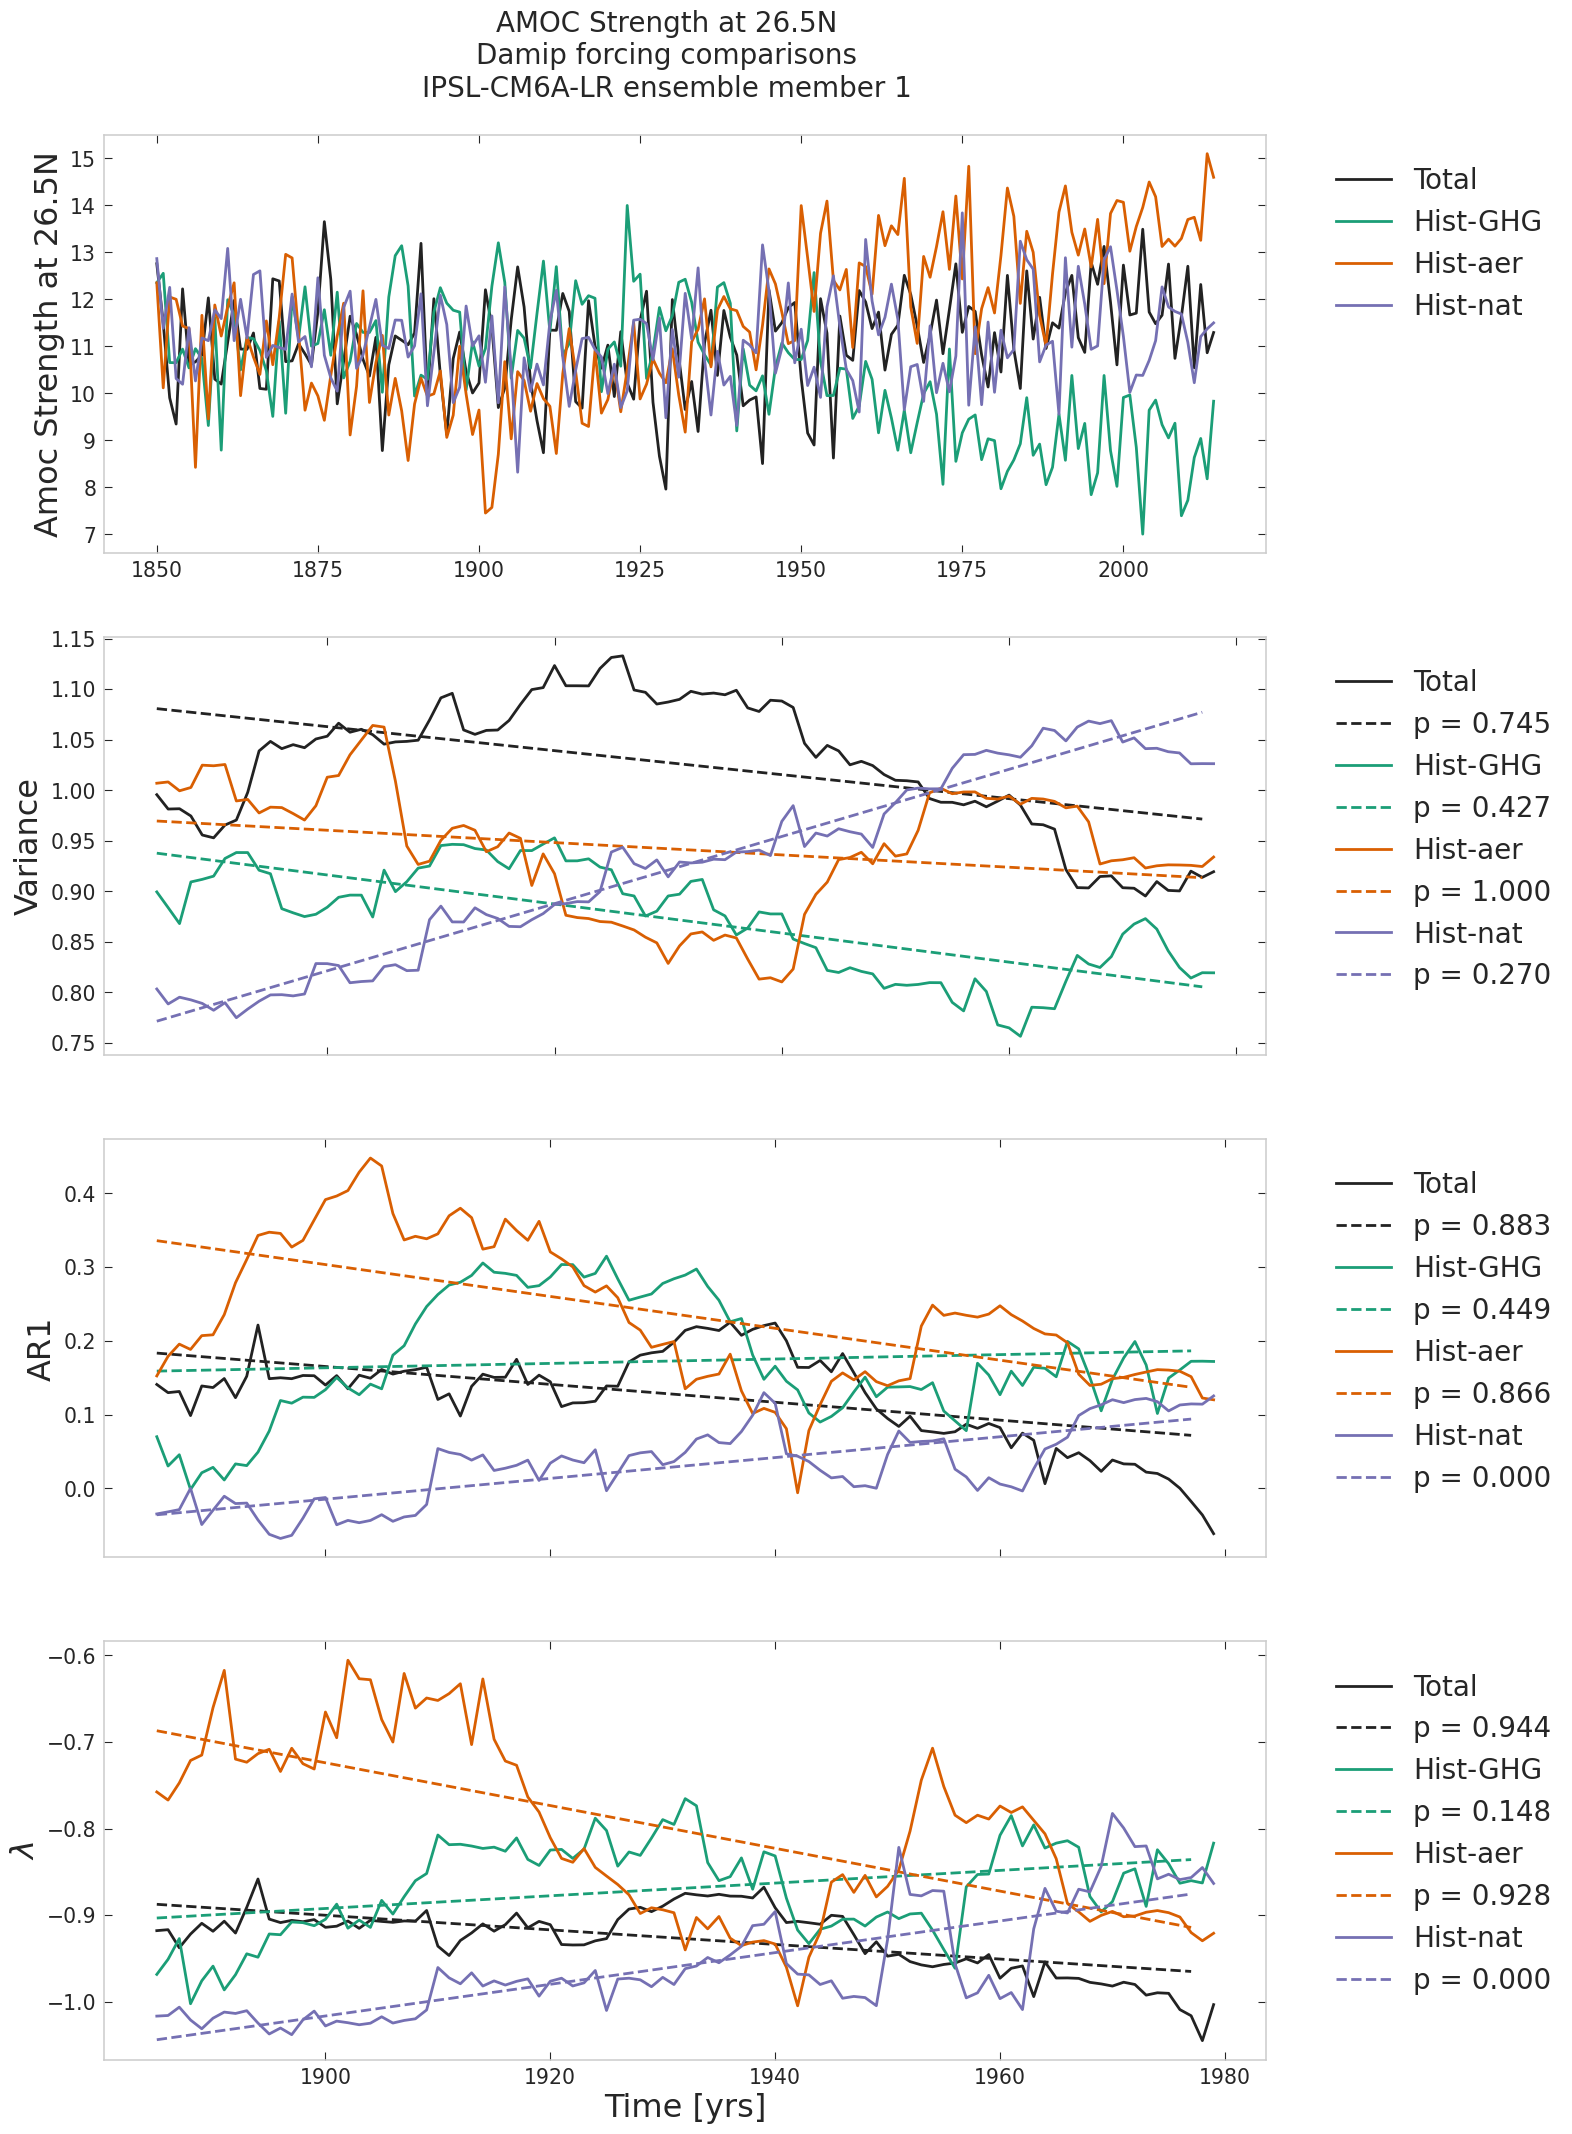

In [45]:
ws = 70
bound = ws // 2

fig, (ax0, ax1,ax2,ax3) = plt.subplots(4,1,figsize=(15,25))

model = 'CanESM5'
model = 'HadGEM3-GC31-LL'
#  'CNRM-CM6-1'
#  'GISS-E2-1-G'
# model = 'MIROC6'
# model = 'CanESM5'
model = 'BCC-CSM2-MR'
model = 'IPSL-CM6A-LR'
i = 0
ens_colors = ['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c','#fdbf6f','#ff7f00','#cab2d6','#6a3d9a']

data = damip_strn.sel(models=model).isel(ensemble_members=i)

amoc = np.array(data.sel(experiments='historical').values,dtype=np.float64)
yrs = data.year.values
ax0.plot(yrs,amoc,label='Total',color='k',lw=2)
plot_EWS(amoc,yrs,ws=ws,col='k',lbl='Total',lw=2)

amoc = np.array(data.sel(experiments='hist-GHG').values,dtype=np.float64)
yrs = data.year.values
ax0.plot(yrs,amoc,label='Hist-GHG',color='C0',lw=2)
plot_EWS(amoc,yrs,ws=ws,col='C0',lbl='Hist-GHG',lw=2)

amoc = np.array(data.sel(experiments='hist-aer').values,dtype=np.float64)
yrs = data.year.values
ax0.plot(yrs,amoc,label='Hist-aer',color='C1',lw=2)
plot_EWS(amoc,yrs,ws=ws,col='C1',lbl='Hist-aer',lw=2)

amoc = np.array(data.sel(experiments='hist-nat').values,dtype=np.float64)
yrs = data.year.values
ax0.plot(yrs,amoc,label='Hist-nat',color='C2',lw=2)
plot_EWS(amoc,yrs,ws=ws,col='C2',lbl='Hist-nat',lw=2)

ax0.set_ylabel('Amoc Strength at 26.5N')
ax0.set_title('')
ax0.set_xlabel('')
ax0.legend(bbox_to_anchor=(1.05, 0.95), loc='upper left', borderaxespad=0., fontsize=20,fancybox=False,frameon=False)


ax1.set_ylabel('Variance')
ax1.legend(bbox_to_anchor=(1.05, 0.95), loc='upper left', borderaxespad=0., fontsize=20,fancybox=False,frameon=False)
ax1.tick_params(axis='x', which='both',bottom=True,top=True,labelbottom=False, labelsize=fontsize)
ax2.set_ylabel('AR1')
ax2.legend(bbox_to_anchor=(1.05, 0.95), loc='upper left', borderaxespad=0., fontsize=20,fancybox=False,frameon=False)
ax2.tick_params(axis='x', which='both',bottom=True,top=True,labelbottom=False, labelsize=fontsize)
ax3.set_ylabel('$\lambda$')
ax3.legend(bbox_to_anchor=(1.05, 0.95), loc='upper left', borderaxespad=0., fontsize=20,fancybox=False,frameon=False)
ax3.set_xlabel('Time [yrs]')

fig.suptitle('AMOC Strength at 26.5N\nDamip forcing comparisons\n{} ensemble member {}'.format(model,i+1),fontsize=20, y=0.93)
# plt.show()

/home/mayayami/AR6/EWS_functions.py:183: RuntimeWarning: invalid value encountered in power
  return a + np.power(-b * (x - c), 1 / 3)
/home/mayayami/AR6/EWS_functions.py:183: RuntimeWarning: invalid value encountered in power
  return a + np.power(-b * (x - c), 1 / 3)


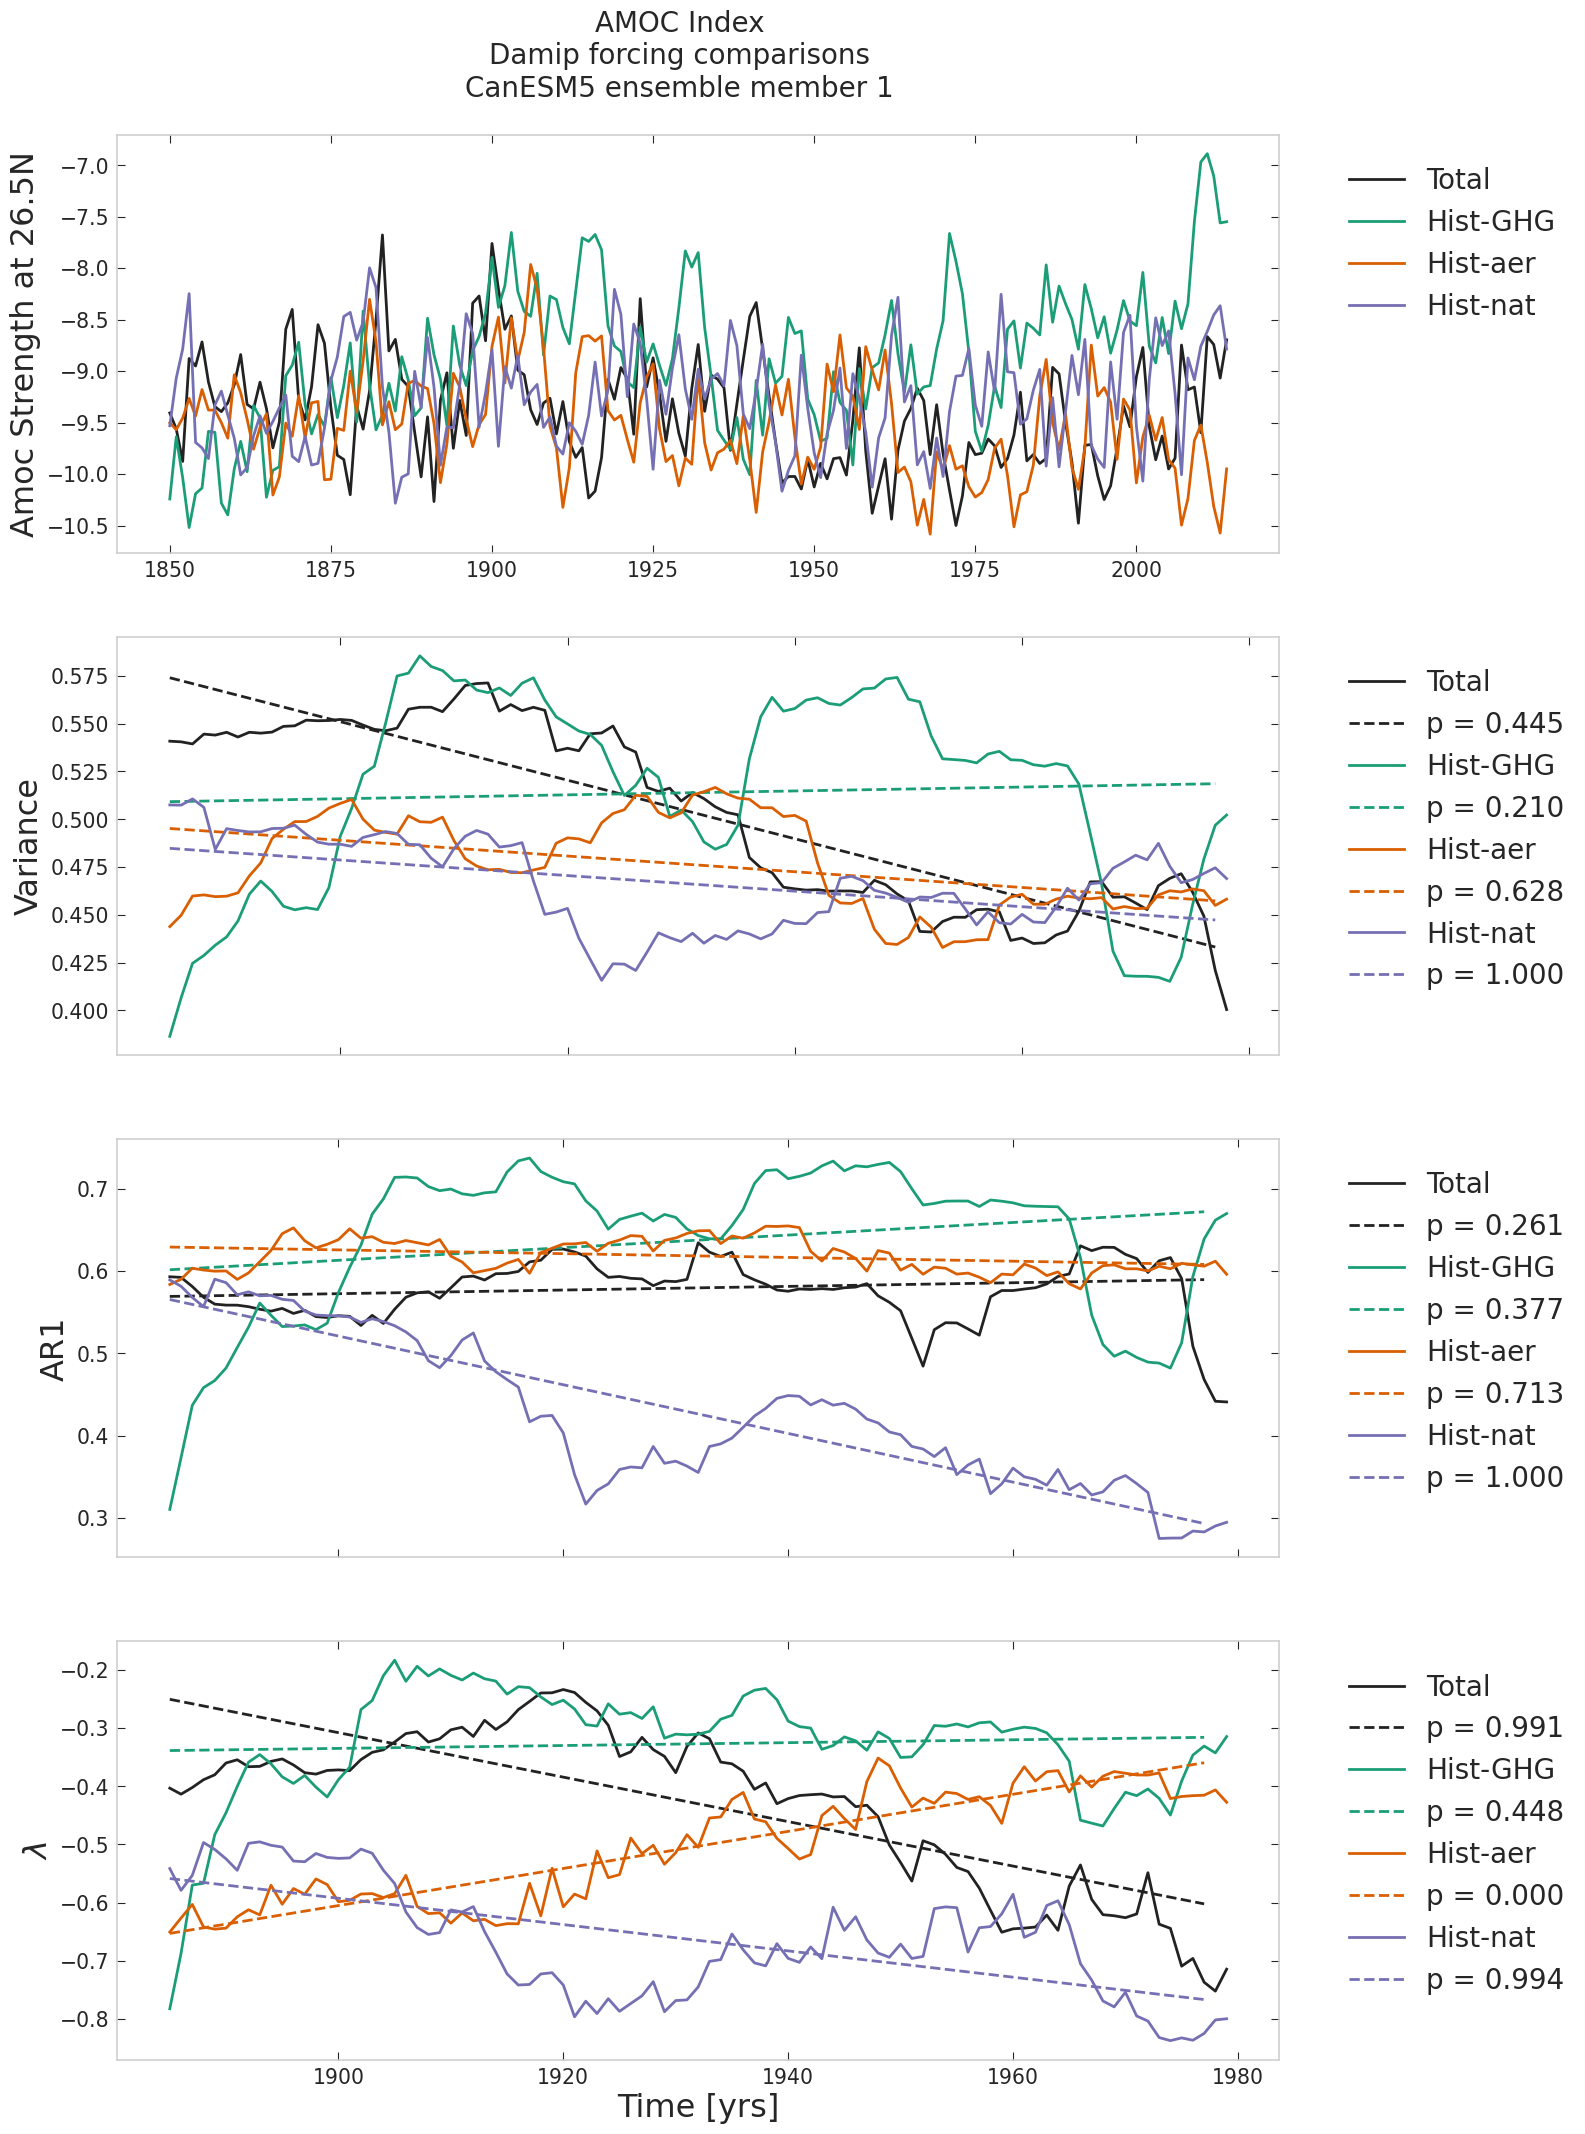

In [37]:
ws = 70
bound = ws // 2

fig, (ax0, ax1,ax2,ax3) = plt.subplots(4,1,figsize=(15,25))

model = 'CanESM5'
# model = 'HadGEM3-GC31-LL'
#  'CNRM-CM6-1'
#  'GISS-E2-1-G'
# model = 'MIROC6'
# model = 'CanESM5'
# #  'BCC-CSM2-MR'
# model = 'IPSL-CM6A-LR'
i = 0
ens_colors = ['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c','#fdbf6f','#ff7f00','#cab2d6','#6a3d9a']

data = damip_index.sel(models=model).isel(ensemble_members=i)

amoc = np.array(data.sel(experiments='historical').values,dtype=np.float64)
yrs = data.year.values
ax0.plot(yrs,amoc,label='Total',color='k',lw=2)
plot_EWS(amoc,yrs,ws=ws,col='k',lbl='Total',lw=2)

amoc = np.array(data.sel(experiments='hist-GHG').values,dtype=np.float64)
yrs = data.year.values
ax0.plot(yrs,amoc,label='Hist-GHG',color='C0',lw=2)
plot_EWS(amoc,yrs,ws=ws,col='C0',lbl='Hist-GHG',lw=2)

amoc = np.array(data.sel(experiments='hist-aer').values,dtype=np.float64)
yrs = data.year.values
ax0.plot(yrs,amoc,label='Hist-aer',color='C1',lw=2)
plot_EWS(amoc,yrs,ws=ws,col='C1',lbl='Hist-aer',lw=2)

amoc = np.array(data.sel(experiments='hist-nat').values,dtype=np.float64)
yrs = data.year.values
ax0.plot(yrs,amoc,label='Hist-nat',color='C2',lw=2)
plot_EWS(amoc,yrs,ws=ws,col='C2',lbl='Hist-nat',lw=2)

ax0.set_ylabel('Amoc Strength at 26.5N')
ax0.set_title('')
ax0.set_xlabel('')
ax0.legend(bbox_to_anchor=(1.05, 0.95), loc='upper left', borderaxespad=0., fontsize=20,fancybox=False,frameon=False)


ax1.set_ylabel('Variance')
ax1.legend(bbox_to_anchor=(1.05, 0.95), loc='upper left', borderaxespad=0., fontsize=20,fancybox=False,frameon=False)
ax1.tick_params(axis='x', which='both',bottom=True,top=True,labelbottom=False, labelsize=fontsize)
ax2.set_ylabel('AR1')
ax2.legend(bbox_to_anchor=(1.05, 0.95), loc='upper left', borderaxespad=0., fontsize=20,fancybox=False,frameon=False)
ax2.tick_params(axis='x', which='both',bottom=True,top=True,labelbottom=False, labelsize=fontsize)
ax3.set_ylabel('$\lambda$')
ax3.legend(bbox_to_anchor=(1.05, 0.95), loc='upper left', borderaxespad=0., fontsize=20,fancybox=False,frameon=False)
ax3.set_xlabel('Time [yrs]')

fig.suptitle('AMOC Index\nDamip forcing comparisons\n{} ensemble member {}'.format(model,i+1),fontsize=20, y=0.93)
plt.show()

# Both analysis

In [34]:
saer = damip_strn.sel(experiments='hist-aer')
snat = damip_strn.sel(experiments='hist-nat')
sghg = damip_strn.sel(experiments='hist-GHG')
shist = damip_strn.sel(experiments='historical')

iaer = damip_index.sel(experiments='hist-aer')
inat = damip_index.sel(experiments='hist-nat')
ighg = damip_index.sel(experiments='hist-GHG')
ihist = damip_index.sel(experiments='historical')

yrs = damip_strn.year


## Correlation at 26.5N

### Trend correlation

In [35]:
def get_trend(yrs,data,nmod=7):
    trend = np.zeros((nmod,10))
    for imod in range(nmod):
        for iens in range(10):
            amc = np.nan_to_num(data.values[imod,iens,:])
            slope, intercept, r, p, se = linregress(yrs, amc)
            trend[imod,iens]=slope*100
    return trend

In [36]:
saer_trend = get_trend(yrs,saer)
snat_trend = get_trend(yrs,snat)
sghg_trend = get_trend(yrs,sghg)
shist_trend = get_trend(yrs,shist)
iaer_trend = get_trend(yrs,iaer)
inat_trend = get_trend(yrs,inat)
ighg_trend = get_trend(yrs,ighg)
ihist_trend = get_trend(yrs,ihist)

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


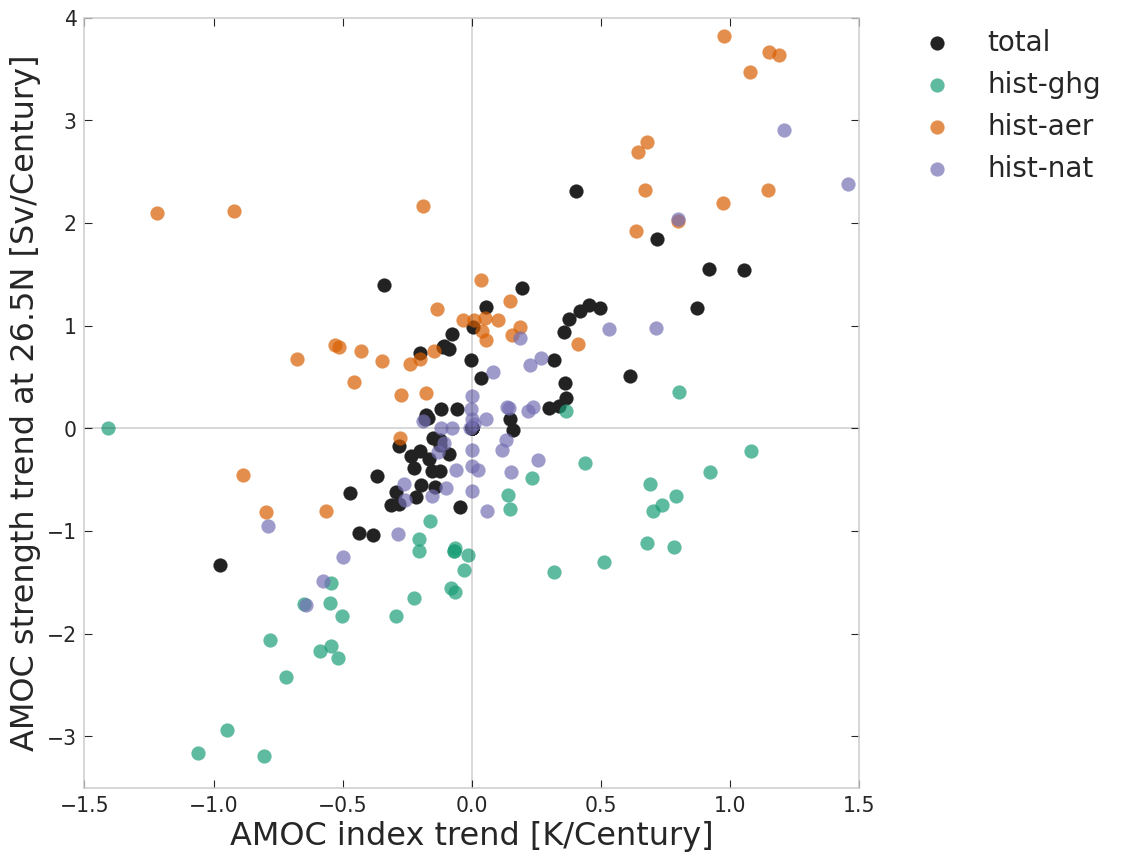

In [37]:
cmap = plt.get_cmap('tab20')
color_list = [cmap(i/34) for i in np.arange(0,34)]
markers = ['x','o','h','s']

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
idc = np.where((iaer_trend!=0)&(saer_trend!=0))
plt.scatter(ihist_trend,shist_trend,color='k',label='total',s=100)
plt.scatter(ighg_trend[idc],sghg_trend[idc],color='C0',label='hist-ghg',s=100,alpha=0.7)
plt.scatter(iaer_trend[idc],saer_trend[idc],color='C1',label='hist-aer',s=100,alpha=0.7)
plt.scatter(inat_trend[idc],snat_trend[idc],color='C2',label='hist-nat',s=100,alpha=0.7)

ax.set_ylim(-3.5,4)
ax.set_xlim(-1.5,1.5)
plt.ylabel('AMOC strength trend at 26.5N [Sv/Century]')
plt.xlabel('AMOC index trend [K/Century]')
plt.hlines(0,-10,10,color='k',alpha=0.2)
plt.vlines(0,-10,10,color='k',alpha=0.2)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., fontsize=20,fancybox=False,frameon=False,ncol=1)
plt.show()

### timeseries correlation

In [18]:
data2_c = pd.read_excel('caesar2021_Data_compilation.xlsx',sheet_name='Caesar et al. (2018)',skiprows=1)
oyear=data2_c['year']
oindex=data2_c['AMOC proxy [K]']
obs_index = xr.DataArray(
    data = oindex,
    dims = ['year'],
    coords = {'year':oyear},
    attrs = dict(
    description='Amoc index from Caesar 2018')
)
oindex2 = obs_index[:-2]
index2 = index[:,:,21:]

In [19]:
damip_model26_corr = xr.corr(damip_index,damip_strn,dim='year')
damip_index_corr = xr.corr(damip_index,oindex2,dim='year')

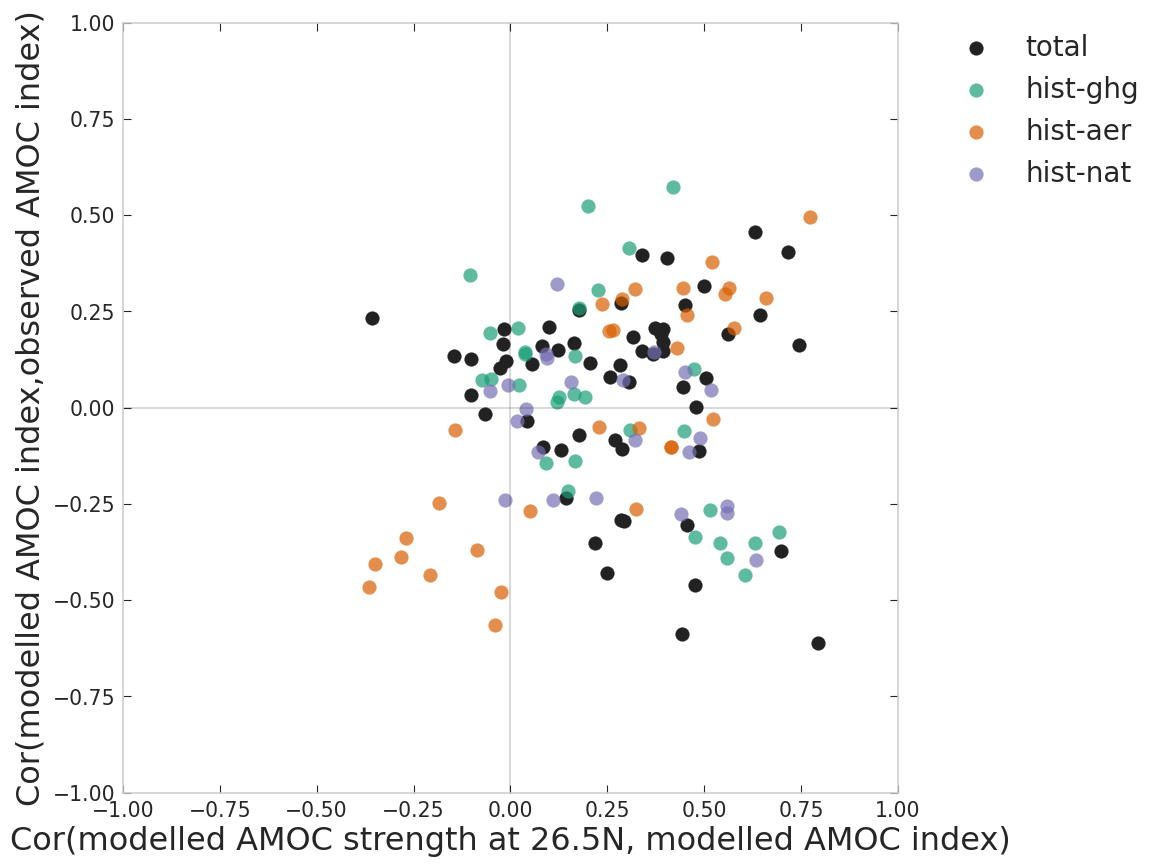

In [20]:
cmap = plt.get_cmap('tab20')
color_list = [cmap(i/34) for i in np.arange(0,34)]
markers = ['x','o','h','s']

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
idc = np.where((iaer!=0)&(saer!=0))
plt.scatter(damip_model26_corr.sel(experiments='historical'),damip_index_corr.sel(experiments='historical'),color='k',label='total',s=100)
plt.scatter(damip_model26_corr.sel(experiments='hist-aer'),damip_index_corr.sel(experiments='hist-aer'),color='C0',label='hist-ghg',s=100,alpha=0.7)
plt.scatter(damip_model26_corr.sel(experiments='hist-GHG'),damip_index_corr.sel(experiments='hist-GHG'),color='C1',label='hist-aer',s=100,alpha=0.7)
plt.scatter(damip_model26_corr.sel(experiments='hist-nat'),damip_index_corr.sel(experiments='hist-nat'),color='C2',label='hist-nat',s=100,alpha=0.7)
ax.set_ylim(-1,1)
ax.set_xlim(-1,1)
plt.ylabel('Cor(modelled AMOC index,observed AMOC index)')
plt.xlabel('Cor(modelled AMOC strength at 26.5N, modelled AMOC index)')
plt.hlines(0,-10,10,color='k',alpha=0.2)
plt.vlines(0,-10,10,color='k',alpha=0.2)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., fontsize=20,fancybox=False,frameon=False,ncol=1)
plt.show()

# lambdas

In [21]:
ds = xr.open_dataset('DAMIP_amoc.nc')
damip_strn26 = ds.amoc_damip.sel(latitudes='26.5N')
damip_strn35 = ds.amoc_damip.sel(latitudes='35N')
damip_index = ds.index_damip

In [22]:
# damip_strn26_lambda = np.full((7,4,10,165),np.nan)
# ws = 70
# bound = ws // 2
# for imod, mod in enumerate(damip6_models):
#     for iens,ens in enumerate(ens_names):
#         for iexp, exp in enumerate(ds.experiments):
#             amoc = np.nan_to_num(damip_strn26[imod,iexp,iens].values)
#             amoc_low = gaussian_filter1d(amoc, 100)
#             if amoc.sum() != 0:
#                 lamb = run_fit_a_ar1(amoc-amoc_low,ws)
#                 damip_strn26_lambda[imod,iexp,iens,:]=lamb

In [23]:
# damip_strn35_lambda = np.full((7,4,10,165),np.nan)
# ws = 70
# bound = ws // 2
# for imod, mod in enumerate(damip6_models):
#     for iens,ens in enumerate(ens_names):
#         for iexp, exp in enumerate(ds.experiments):
#             amoc = np.nan_to_num(damip_strn35[imod,iexp,iens].values)
#             amoc_low = gaussian_filter1d(amoc, 100)
#             if amoc.sum() != 0:
#                 lamb = run_fit_a_ar1(amoc-amoc_low,ws)
#                 damip_strn35_lambda[imod,iexp,iens,:]=lamb

In [24]:
# damip_index_lambda = np.full((7,4,10,165),np.nan)
# ws = 70
# bound = ws // 2
# for imod, mod in enumerate(damip6_models):
#     for iens,ens in enumerate(ens_names):
#         for iexp, exp in enumerate(ds.experiments):
#             amoc = np.nan_to_num(damip_index[imod,iexp,iens].values)
#             amoc_low = gaussian_filter1d(amoc, 100)
#             if amoc.sum() != 0:
#                 lamb = run_fit_a_ar1(amoc-amoc_low,ws)
#                 damip_index_lambda[imod,iexp,iens,:]=lamb

In [25]:
# damip_amoc26_lambda = xr.DataArray(
#     data = damip_strn26_lambda,
#     dims = ('models', 'experiments','ensemble_members', 'time'),
#     coords = dict(
#             models      = xr.DataArray(damip6_models, dims="models", coords=dict(models=("models", damip6_models))),
#             time        = xr.DataArray(yrs.values, dims="time", coords=dict(time=("time", yrs.values))),
#             experiments = ['historical', 'hist-aer', 'hist-GHG', 'hist-nat'],
#             ensemble_members = xr.DataArray(ens_names, dims="ensemble_members", coords=dict(ensemble_members=("ensemble_members", ens_names)))),
#     attrs = dict(
#     description='DAMIP Amoc lambda from 26.5N strength')
# )
# damip_amoc35_lambda = xr.DataArray(
#     data = damip_strn35_lambda,
#     dims = ('models', 'experiments','ensemble_members', 'time'),
#     coords = dict(
#             models      = xr.DataArray(damip6_models, dims="models", coords=dict(models=("models", damip6_models))),
#             time        = xr.DataArray(yrs.values, dims="time", coords=dict(time=("time", yrs.values))),
#             experiments = ['historical', 'hist-aer', 'hist-GHG', 'hist-nat'],
#             ensemble_members = xr.DataArray(ens_names, dims="ensemble_members", coords=dict(ensemble_members=("ensemble_members", ens_names)))),
#     attrs = dict(
#     description='DAMIP Amoc lambda from 35N strength')
# )
# damip_index_lambda = xr.DataArray(
#     data = damip_index_lambda,
#     dims = ('models', 'experiments','ensemble_members', 'time'),
#     coords = dict(
#             models      = xr.DataArray(damip6_models, dims="models", coords=dict(models=("models", damip6_models))),
#             time        = xr.DataArray(yrs.values, dims="time", coords=dict(time=("time", yrs.values))),
#             experiments = ['historical', 'hist-aer', 'hist-GHG', 'hist-nat'],
#             ensemble_members = xr.DataArray(ens_names, dims="ensemble_members", coords=dict(ensemble_members=("ensemble_members", ens_names)))),
#     attrs = dict(
#     description='DAMIP Amoc lambda from SST Index')
# )

In [26]:
# ws = 70
# bound = ws // 2
# tt =yrs[bound:-bound]
# damip_strn26_lambda_pv = np.full((7,4,10),np.nan)
# for imod, mod in enumerate(damip6_models):
#     for iens,ens in enumerate(ens_names):
#         for iexp, exp in enumerate(ds.experiments):
#             lam = damip_amoc26_lambda[imod,iexp,iens,:][bound : -bound]
#             if lam.sum() != 0:
#                 p0, p1 = np.polyfit(tt[:-2], lam[:-2], 1)
#                 pv = kendall_tau_test(lam[:-2], 1000, p0)
#                 damip_strn26_lambda_pv[imod,iexp,iens]=pv

In [27]:
# ws = 70
# bound = ws // 2
# tt =yrs[bound:-bound]
# damip_strn35_lambda_pv = np.full((7,4,10),np.nan)
# for imod, mod in enumerate(damip6_models):
#     for iens,ens in enumerate(ens_names):
#         for iexp, exp in enumerate(ds.experiments):
#             lam = damip_amoc35_lambda[imod,iexp,iens,:][bound : -bound]
#             if lam.sum() != 0:
#                 p0, p1 = np.polyfit(tt[:-2], lam[:-2], 1)
#                 pv = kendall_tau_test(lam[:-2], 1000, p0)
#                 damip_strn35_lambda_pv[imod,iexp,iens]=pv

In [28]:
# ws = 70
# bound = ws // 2
# tt =yrs[bound:-bound]
# damip_index_lambda_pv = np.full((7,4,10),np.nan)
# for imod, mod in enumerate(damip6_models):
#     for iens,ens in enumerate(ens_names):
#         for iexp, exp in enumerate(ds.experiments):
#             lam = damip_index_lambda[imod,iexp,iens,:][bound : -bound]
#             if lam.sum() != 0:
#                 p0, p1 = np.polyfit(tt[:-2], lam[:-2], 1)
#                 pv = kendall_tau_test(lam[:-2], 1000, p0)
#                 damip_index_lambda_pv[imod,iexp,iens]=pv

In [29]:
# damip_lambda_pvs = xr.Dataset(
#     data_vars = dict(damip_strn26_lambda_pv=(['models', 'experiments', 'ensemble_members'],damip_strn26_lambda_pv),
#                      damip_strn35_lambda_pv=(['models', 'experiments', 'ensemble_members'],damip_strn35_lambda_pv),
#                      damip_index_lambda_pv=(['models', 'experiments', 'ensemble_members'],damip_index_lambda_pv)),
#     coords = dict(
#             models      = xr.DataArray(damip6_models, dims="models", coords=dict(models=("models", damip6_models))),
#             experiments = ['historical', 'hist-aer', 'hist-GHG', 'hist-nat'],
#             ensemble_members = xr.DataArray(ens_names, dims="ensemble_members", coords=dict(ensemble_members=("ensemble_members", ens_names)))),
#     attrs = dict(
#     description='pvs of the lambda of strength and index in the DAMIP experiments')
# )

In [30]:
damip_lambda_pvs = xr.open_dataset('damip_lambda_pvs.nc')
damip_strn26_lambda_pv = damip_lambda_pvs.damip_strn26_lambda_pv
damip_strn35_lambda_pv = damip_lambda_pvs.damip_strn35_lambda_pv
damip_index_lambda_pv = damip_lambda_pvs.damip_index_lambda_pv

damip_amoc26_lambda = xr.open_dataset('strn26_damip_lam.nc')
damip_amoc35_lambda = xr.open_dataset('strn35_damip_lam.nc')
damip_index_lambda = xr.open_dataset('index_damip_lam.nc')

In [31]:
def print_num(data,exp):
    tot = cc
    print(exp,':  ', len(np.where(data.sel(experiments=exp)<=0.05)[0]),' / ',tot)

In [32]:
print('\nSignificant lambda incease in strn26:  ')
print_num(damip_strn26_lambda_pv,'historical')
print_num(damip_strn26_lambda_pv,'hist-aer')
print_num(damip_strn26_lambda_pv,'hist-GHG')
print_num(damip_strn26_lambda_pv,'hist-nat')

print('\nSignificant lambda incease in strn35:  ')
print_num(damip_strn35_lambda_pv,'historical')
print_num(damip_strn35_lambda_pv,'hist-aer')
print_num(damip_strn35_lambda_pv,'hist-GHG')
print_num(damip_strn35_lambda_pv,'hist-nat')

print('\nSignificant lambda incease in index:  ')
print_num(damip_index_lambda_pv,'historical')
print_num(damip_index_lambda_pv,'hist-aer')
print_num(damip_index_lambda_pv,'hist-GHG')
print_num(damip_index_lambda_pv,'hist-nat')
# print('Out of ',np.count_nonzero(~np.isnan(damip_strn26_lambda_pv)))


Significant lambda incease in strn26:  
historical :   14  /  57
hist-aer :   9  /  45
hist-GHG :   11  /  44
hist-nat :   15  /  42

Significant lambda incease in strn35:  
historical :   17  /  57
hist-aer :   15  /  45
hist-GHG :   11  /  44
hist-nat :   12  /  42

Significant lambda incease in index:  
historical :   11  /  57
hist-aer :   10  /  38
hist-GHG :   9  /  38
hist-nat :   5  /  33


In [33]:
print('Significant lambda incease in index & strn25:  ',len(np.where((damip_index_lambda_pv <=0.05)&(damip_strn26_lambda_pv <=0.05))[0]))
print('Out of ',np.count_nonzero(~np.isnan(damip_index_lambda_pv)))

Significant lambda incease in index & strn25:   11
Out of  166


In [34]:
damip_strn26_EWS = np.full((7,4,10), np.nan)
damip_strn26_EWS[np.where(damip_strn26_lambda_pv>0.06)] = False
damip_strn26_EWS[np.where(damip_strn26_lambda_pv<=0.06)] = True

damip_strn35_EWS = np.full((7,4,10), np.nan)
damip_strn35_EWS[np.where(damip_strn35_lambda_pv>0.06)] = False
damip_strn35_EWS[np.where(damip_strn35_lambda_pv<=0.06)] = True

damip_index_EWS = np.full((7,4,10), np.nan)
damip_index_EWS[np.where(damip_index_lambda_pv>0.06)] = False
damip_index_EWS[np.where(damip_index_lambda_pv<=0.06)] = True

In [35]:
print('------------------ FIRST ENSEMBLE MEMBER')
df = pd.DataFrame(data=damip_strn35_EWS[:,:,0],
                   columns=ds.experiments,index=damip6_models)
print('Stength 35N')
display(df)
df = pd.DataFrame(data=damip_index_EWS[:,:,0],
                   columns=ds.experiments,index=damip6_models)
print('Index')
display(df)

------------------ FIRST ENSEMBLE MEMBER
Stength 35N


historical  hist-aer  hist-GHG  hist-nat
HadGEM3-GC31-LL         1.0       1.0       0.0       0.0
CNRM-CM6-1              0.0       0.0       0.0       0.0
GISS-E2-1-G             0.0       0.0       1.0       0.0
MIROC6                  0.0       0.0       0.0       NaN
CanESM5                 1.0       1.0       0.0       0.0
BCC-CSM2-MR             0.0       0.0       0.0       0.0
IPSL-CM6A-LR            0.0       0.0       0.0       1.0

Index


historical  hist-aer  hist-GHG  hist-nat
HadGEM3-GC31-LL         0.0       NaN       NaN       NaN
CNRM-CM6-1              0.0       NaN       NaN       NaN
GISS-E2-1-G             0.0       0.0       1.0       NaN
MIROC6                  1.0       1.0       1.0       0.0
CanESM5                 0.0       1.0       0.0       0.0
BCC-CSM2-MR             0.0       0.0       0.0       0.0
IPSL-CM6A-LR            0.0       0.0       0.0       0.0

In [38]:
print('------------------ SECOND ENSEMBLE MEMBER')
df = pd.DataFrame(data=damip_strn35_EWS[:,:,1],
                   columns=ds.experiments,index=damip6_models)
print('Stength 35N')
display(df)
df = pd.DataFrame(data=damip_index_EWS[:,:,1],
                   columns=ds.experiments,index=damip6_models)
print('Index')
display(df)

------------------ SECOND ENSEMBLE MEMBER
Stength 35N


historical  hist-aer  hist-GHG  hist-nat
HadGEM3-GC31-LL         1.0       1.0       0.0       0.0
CNRM-CM6-1              0.0       1.0       1.0       1.0
GISS-E2-1-G             1.0       0.0       1.0       1.0
MIROC6                  0.0       0.0       0.0       NaN
CanESM5                 0.0       0.0       0.0       0.0
BCC-CSM2-MR             0.0       0.0       0.0       1.0
IPSL-CM6A-LR            0.0       0.0       1.0       0.0

Index


historical  hist-aer  hist-GHG  hist-nat
HadGEM3-GC31-LL         0.0       NaN       NaN       NaN
CNRM-CM6-1              0.0       NaN       NaN       NaN
GISS-E2-1-G             1.0       0.0       0.0       NaN
MIROC6                  0.0       0.0       0.0       0.0
CanESM5                 1.0       0.0       1.0       1.0
BCC-CSM2-MR             0.0       0.0       0.0       0.0
IPSL-CM6A-LR            1.0       0.0       0.0       0.0